# Base model for stock prediction

In [1]:
from tools.log_controller import LogController
from pathlib import Path

log_controller = LogController(config_path=Path('config', 'logging_config.json'))
log_controller.start()

 2025-09-26 11:25:53 - data_repository - INFO - Loaded: AAPL
 2025-09-26 11:25:53 - data_repository - INFO - Loaded: AMZN_enhanced
 2025-09-26 11:25:53 - data_repository - INFO - Loaded: IBM
 2025-09-26 11:25:53 - data_repository - INFO - Loaded: AMZN
 2025-09-26 11:25:53 - data_repository - INFO - Loaded periodic stock market data for: {'AAPL', 'AMZN', 'AMZN_enhanced', 'IBM'}


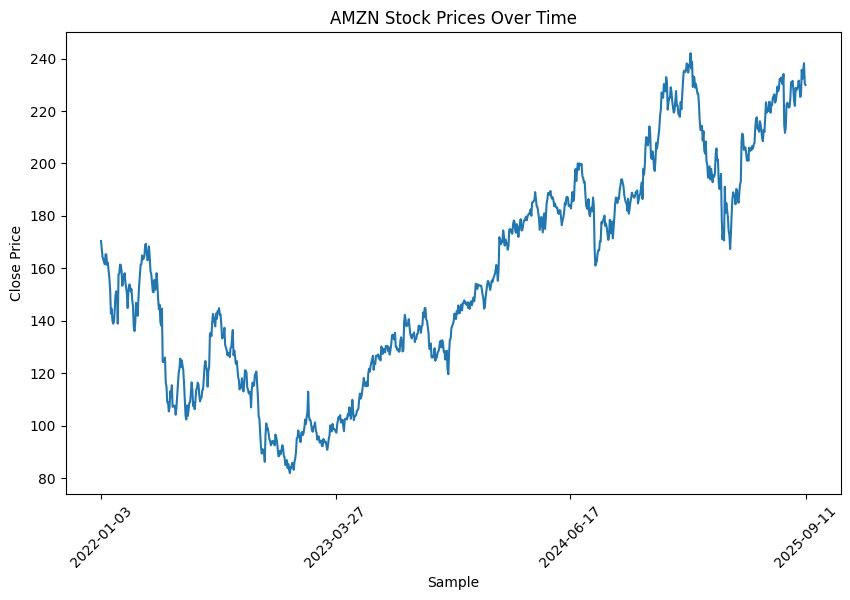

In [2]:
from core.data_repository import DataRepository
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

data_repository = DataRepository(repo_path=Path('repo'))
AMZN_periodic_data = data_repository.get_dataframes()['AMZN']

plt.figure(figsize=(10, 6))
sns.lineplot(data=AMZN_periodic_data, x=AMZN_periodic_data.index, y='Close')
plt.xticks(ticks=np.linspace(0, len(AMZN_periodic_data.index) - 1, 4, dtype=int),rotation=45)
plt.title('AMZN Stock Prices Over Time')
plt.xlabel('Sample')
plt.ylabel('Close Price')
plt.show()

In [3]:
from core.data_preparator import DataPreparator

timesteps_lookback = 3

AMZN_supervised_data = DataPreparator.reformat_periodic_to_supervised_data(
    dataframe=AMZN_periodic_data,
    target_column='Close',
    t=timesteps_lookback
)

AMZN_supervised_data

 2025-09-26 11:25:55 - data_preparator - INFO - Preparing data for target column: Close, with t=3


,Close,Close_0,Close_1,Close_2
Date,,,,
2022-01-06,163.253998,164.356995,167.522003,170.404495
2022-01-07,162.554001,163.253998,164.356995,167.522003
2022-01-10,161.485992,162.554001,163.253998,164.356995
2022-01-11,165.362000,161.485992,162.554001,163.253998
2022-01-12,165.207001,165.362000,161.485992,162.554001
...,...,...,...,...
2025-09-05,232.330002,235.679993,225.990005,225.339996
2025-09-08,235.839996,232.330002,235.679993,225.990005
2025-09-09,238.240005,235.839996,232.330002,235.679993


In [4]:
from core.dataset import StockDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

AMZN_train_dataset, AMZN_test_dataset = train_test_split(AMZN_supervised_data, test_size=.1, shuffle=False, random_state=42)
AMZN_train_dataset, AMZN_validation_dataset = train_test_split(AMZN_train_dataset, test_size=.2, shuffle=False, random_state=42)

In [5]:
target = 'Close'
features = [col for col in AMZN_supervised_data.columns if col != target]

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

scaler_X.fit(AMZN_train_dataset[features])
scaler_y.fit(AMZN_train_dataset[[target]])

X_train_scaled = scaler_X.transform(AMZN_train_dataset[features])
y_train_scaled = scaler_y.transform(AMZN_train_dataset[[target]])

X_validation_scaled = scaler_X.transform(AMZN_validation_dataset[features])
y_validation_scaled = scaler_y.transform(AMZN_validation_dataset[[target]])

X_test_scaled = scaler_X.transform(AMZN_test_dataset[features])
y_test_scaled = scaler_y.transform(AMZN_test_dataset[[target]])

AMZN_train_scaled = pd.DataFrame(X_train_scaled, columns=features)
AMZN_train_scaled[target] = y_train_scaled

AMZN_validation_scaled = pd.DataFrame(X_validation_scaled, columns=features)
AMZN_validation_scaled[target] = y_validation_scaled

AMZN_test_scaled = pd.DataFrame(X_test_scaled, columns=features)
AMZN_test_scaled[target] = y_test_scaled

AMZN_train_dataset = AMZN_train_scaled
AMZN_validation_dataset = AMZN_validation_scaled
AMZN_test_dataset = AMZN_test_scaled

In [6]:
display(AMZN_train_dataset.shape, AMZN_validation_dataset.shape, AMZN_test_dataset.shape)
display(AMZN_train_dataset.head(), AMZN_validation_dataset.head(), AMZN_test_dataset.head())

(664, 4)

(166, 4)

(93, 4)

,Close_0,Close_1,Close_2,Close
0,0.698401,0.725182,0.749573,0.689068
1,0.689068,0.698401,0.725182,0.683144
2,0.683144,0.689068,0.698401,0.674107
3,0.674107,0.683144,0.689068,0.706905
4,0.706905,0.674107,0.683144,0.705593


,Close_0,Close_1,Close_2,Close
0,0.752919,0.772550,0.792689,0.764089
1,0.764089,0.752919,0.772550,0.818074
2,0.818074,0.764089,0.752919,0.799035
3,0.799035,0.818074,0.764089,0.774327
4,0.774327,0.799035,0.818074,0.812913


,Close_0,Close_1,Close_2,Close
0,0.893298,0.895921,0.906837,0.868167
1,0.868167,0.893298,0.895921,0.917076
2,0.917076,0.868167,0.893298,0.915214
3,0.915214,0.917076,0.868167,0.884498
4,0.884498,0.915214,0.917076,0.873160


In [7]:
AMZN_train_dataset = StockDataset(AMZN_train_dataset)
AMZN_validation_dataset = StockDataset(AMZN_validation_dataset)
AMZN_test_dataset = StockDataset(AMZN_test_dataset)

 2025-09-26 11:25:58 - dataset - INFO - Created stock dataset for AMZN, focusing target: Close
 2025-09-26 11:25:58 - dataset - INFO - Created stock dataset for AMZN, focusing target: Close
 2025-09-26 11:25:58 - dataset - INFO - Created stock dataset for AMZN, focusing target: Close


In [8]:
from models.lstm_model import LSTMStockModel

AMZN_base_model = LSTMStockModel(
    id='base_amzn_model',
    ticker='AMZN',
    input_dim=1,
    hidden_dim=64,
    layer_dim=1,
    output_dim=1
)

 2025-09-26 11:25:58 - model - INFO - Model(id=base_amzn_model,
ticker=('AMZN',),
input_dimension=1),
hidden_dimension=64,
layer_dimension=1,
output_dimension=1)


In [9]:
from torch.optim import Adam
from torch.nn import MSELoss

optimizer = Adam(AMZN_base_model.parameters(), lr=0.001)
loss_function = MSELoss()

In [10]:
from torch.utils.data import DataLoader
import torch
import numpy as np


AMZN_train_data_loader = DataLoader(AMZN_train_dataset, batch_size=16, shuffle=False)
AMZN_validation_data_loader = DataLoader(AMZN_validation_dataset, batch_size=10, shuffle=False)


train_rmse_list = []
val_rmse_list = []

predictions = []
actuals = []
epochs = 20

for epoch in range(epochs):
    # Training loop
    AMZN_base_model.train()
    train_loss = 0
    for X,y in AMZN_train_data_loader:
        optimizer.zero_grad()
        X, y = X.reshape(-1,timesteps_lookback,1), y.reshape(-1,1) # Adjust for t
        outputs, _ = AMZN_base_model(X)
        loss = loss_function(outputs, y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        predictions.extend(outputs.detach().numpy().flatten())
        actuals.extend(y.numpy().flatten())
        
    # Validation loop
    AMZN_base_model.eval()
    val_loss = 0
    with torch.no_grad():
        for X,y in AMZN_validation_data_loader:
            X, y = X.reshape(-1,timesteps_lookback,1), y.reshape(-1,1)
            outputs, _ = AMZN_base_model(X)
            val_loss += loss_function(outputs, y).item()
            
    train_rmse = np.sqrt(train_loss / len(AMZN_train_data_loader))
    val_rmse = np.sqrt(val_loss / len(AMZN_validation_data_loader))
    
    train_rmse_list.append(train_rmse)
    val_rmse_list.append(val_rmse)
        
    print(f'Epoch [{epoch+1}/{epochs}]')
    print(f'RMSE: {train_rmse:.4f}')
    print(f'Validation RMSE: {val_rmse:.4f}')

Epoch [1/20]
RMSE: 0.3184
Validation RMSE: 0.4362
Epoch [2/20]
RMSE: 0.2970
Validation RMSE: 0.4897
Epoch [3/20]
RMSE: 0.2327
Validation RMSE: 0.3618
Epoch [4/20]
RMSE: 0.2158
Validation RMSE: 0.2726
Epoch [5/20]
RMSE: 0.1779
Validation RMSE: 0.1237
Epoch [6/20]
RMSE: 0.1292
Validation RMSE: 0.0587
Epoch [7/20]
RMSE: 0.0786
Validation RMSE: 0.0868
Epoch [8/20]
RMSE: 0.0496
Validation RMSE: 0.0647
Epoch [9/20]
RMSE: 0.0468
Validation RMSE: 0.0589
Epoch [10/20]
RMSE: 0.0477
Validation RMSE: 0.0566
Epoch [11/20]
RMSE: 0.0487
Validation RMSE: 0.0545
Epoch [12/20]
RMSE: 0.0499
Validation RMSE: 0.0530
Epoch [13/20]
RMSE: 0.0515
Validation RMSE: 0.0523
Epoch [14/20]
RMSE: 0.0535
Validation RMSE: 0.0522
Epoch [15/20]
RMSE: 0.0558
Validation RMSE: 0.0528
Epoch [16/20]
RMSE: 0.0583
Validation RMSE: 0.0536
Epoch [17/20]
RMSE: 0.0609
Validation RMSE: 0.0546
Epoch [18/20]
RMSE: 0.0631
Validation RMSE: 0.0554
Epoch [19/20]
RMSE: 0.0647
Validation RMSE: 0.0558
Epoch [20/20]
RMSE: 0.0658
Validation RM

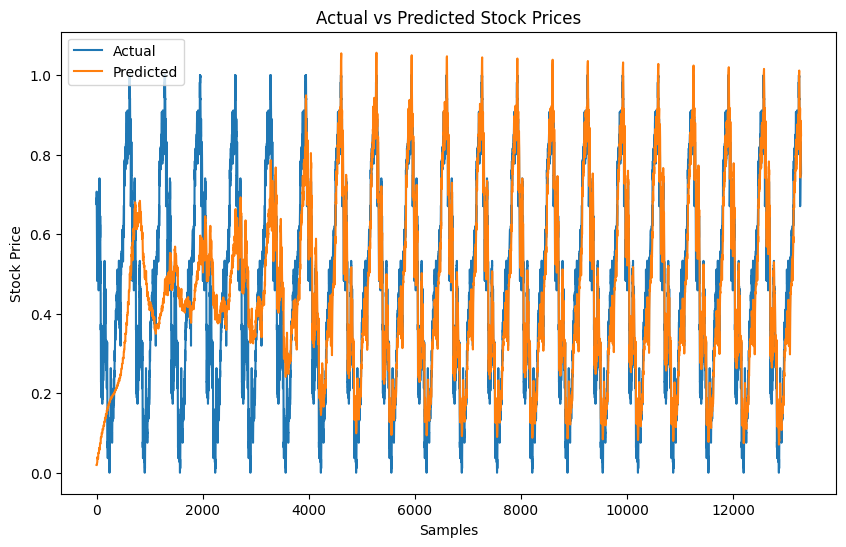

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 6))
sns.lineplot(x=range(len(actuals)), y=actuals, label='Actual')
sns.lineplot(x=range(len(predictions)), y=predictions, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

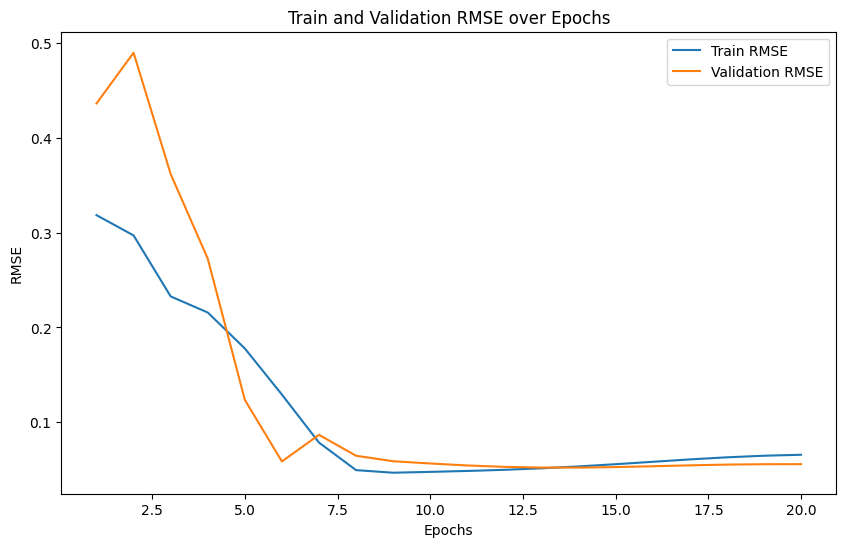

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

epochs_range = range(1, epochs + 1)
plt.figure(figsize=(10, 6))
sns.lineplot(x=epochs_range, y=train_rmse_list, label='Train RMSE')
sns.lineplot(x=epochs_range, y=val_rmse_list, label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Train and Validation RMSE over Epochs')
plt.legend()
plt.show()

In [13]:
AMZN_base_model.eval()
AMZN_test_data_loader = DataLoader(AMZN_test_dataset, batch_size=10, shuffle=False)
test_loss = 0

predictions = []
actuals = []

with torch.no_grad():
    for X,y in AMZN_test_data_loader:
        X, y = X.reshape(-1,timesteps_lookback,1), y.reshape(-1,1)
        outputs, _ = AMZN_base_model(X)
        test_loss += loss_function(outputs, y).item()
        predictions.extend(outputs.numpy().flatten())
        actuals.extend(y.numpy().flatten())

test_rmse = np.sqrt(test_loss / len(AMZN_test_data_loader))
print(f'Test RMSE: {test_rmse:.4f}')

Test RMSE: 0.0400


In [14]:
import numpy as np
predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
actuals = scaler_y.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()
errors = actuals - predictions

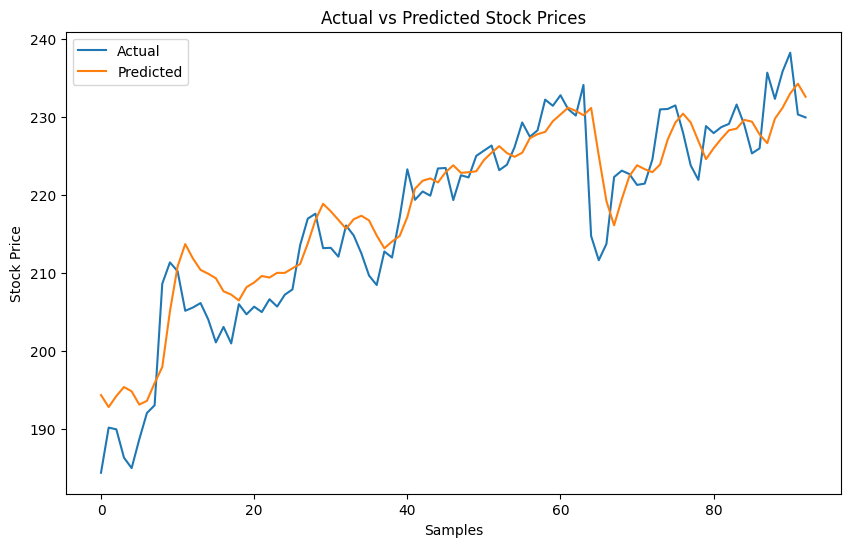

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns




plt.figure(figsize=(10, 6))
sns.lineplot(x=range(len(actuals)), y=actuals, label='Actual')
sns.lineplot(x=range(len(predictions)), y=predictions, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

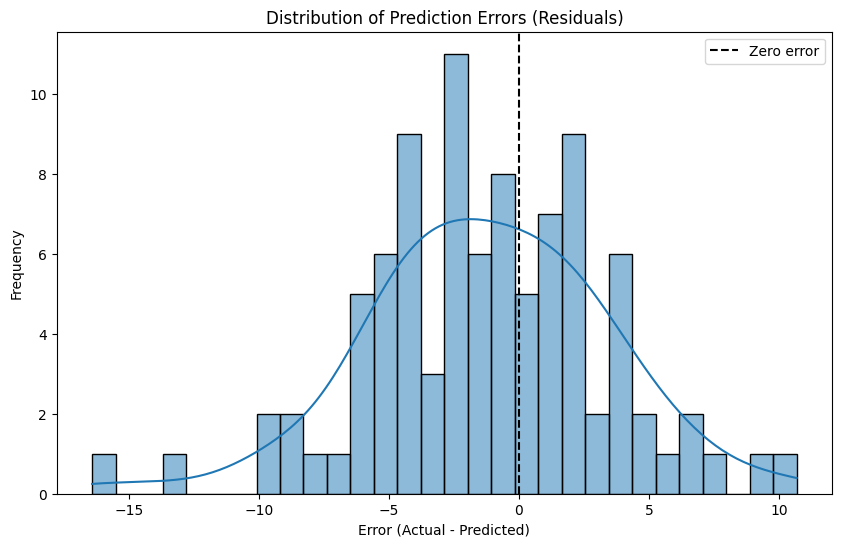

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=30, kde=True)
plt.axvline(0, color='black', linestyle='--', label='Zero error')
plt.title('Distribution of Prediction Errors (Residuals)')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.legend()
plt.show()